<a href="https://colab.research.google.com/github/tumblingdice512/Research/blob/master/model5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [439]:
N = 10
L = 5

In [440]:
torch.manual_seed(100)

In [441]:
S0 = torch.sign(torch.randn(20,N))

SL = torch.sign(torch.randn(20,N))


M = S0.size()[0]
print(M)
print(N)
print(S0.shape)
print(S0[0].shape)

20
10
torch.Size([20, 10])
torch.Size([10])


In [442]:
alpha = M / N
print(alpha)

2.0


In [443]:
D = torch.Tensor([[1,2,3],[2,3,4]])
print(D)
print(D.shape)
print("M:",D.size()[0]) #M
print("N:",D.size()[1]) #N

tensor([[1., 2., 3.],
        [2., 3., 4.]])
torch.Size([2, 3])
M: 2
N: 3


In [444]:
def spin_overlap(x,y):
  spin_overlap = 0
  for i in range (len(x[0])) :

    spin_overlap = spin_overlap + torch.dot(x.T[i],y.T[i])
  return torch.abs(spin_overlap/(x.size()[0]*x.size()[1]))

print(spin_overlap(S0,S0))


tensor(1.)


In [445]:
def bond_overlap(x,y):
  bond_overlap = 0
  for i in range (len(x[0])) :

    bond_overlap = bond_overlap + torch.dot(x[i],y[i])
  return torch.abs(bond_overlap/(x.size()[0]*x.size()[1]))

#pytorchではネットワークで定義する重みの転置を計算に用いるので、行方向が同じパーセプトロンに対応

In [446]:
S_a = torch.Tensor([[1,-1],[-1,1],[1,-1]])
S_b = torch.Tensor([[1,-1],[1,1],[1,1]])
print(spin_overlap(S_a,S_b))
print(spin_overlap(S_a,S_a))

tensor(0.3333)
tensor(1.)


In [447]:
a1 = torch.dot(S_a.T[0],S_b.T[0])
a2 = torch.dot(S_a.T[1],S_b.T[1])
a3 = (a1 + a2)/(2*3)
print(a3)

tensor(0.3333)


In [448]:
def MSE(t, y):
    mse = torch.mean(torch.sum(torch.square(t-y),axis = 1),axis = 0)
    return mse

In [449]:
print(MSE(S0,SL))

tensor(22.)


In [450]:
A = torch.Tensor([[3,5,1],[4,12,1]])
print(A**2)
A_norm = (torch.sum(torch.square(A),axis=0))**(1/2)

A_normalized = A / A_norm
A_normalized_2 = A / A_norm * (N**(1/2))

print(A_norm)

print(A_normalized)
print(A_normalized_2)

tensor([[  9.,  25.,   1.],
        [ 16., 144.,   1.]])
tensor([ 5.0000, 13.0000,  1.4142])
tensor([[0.6000, 0.3846, 0.7071],
        [0.8000, 0.9231, 0.7071]])
tensor([[1.8974, 1.2163, 2.2361],
        [2.5298, 2.9190, 2.2361]])


In [451]:
def weight_norm(x):
    x_norm = (torch.sum(torch.square(x),axis=0)**(1/2))
    return x_norm

In [452]:
w_a = torch.Tensor([[1,0,1],[1,2,0],[0,1,0]]) 
w_b = torch.Tensor([[1,0,0],[0,1,0],[0,0,1]]) 
J_a = w_a / (weight_norm(w_a)) * (3**(1/2))
J_b = w_b / (weight_norm(w_b)) * (3**(1/2))


print(J_a)
print(J_b)
print(len(J_a[0]))

print(bond_overlap(J_a,J_b))
print(bond_overlap(J_a,J_a))

tensor([[1.2247, 0.0000, 1.7321],
        [1.2247, 1.5492, 0.0000],
        [0.0000, 0.7746, 0.0000]])
tensor([[1.7321, 0.0000, 0.0000],
        [0.0000, 1.7321, 0.0000],
        [0.0000, 0.0000, 1.7321]])
3
tensor(0.5338)
tensor(1.)


In [453]:
c = torch.nn.utils.weight_norm(torch.nn.Linear(4, 3, False), name='weight',dim=0)
#計算の際にはcの転置を用いる。正規化は、dim=0で行う必要あり。
print(c.weight)
print(c.weight_g)
d = c.weight/c.weight_g
print(d)
print(c.weight_v.size())

tensor([[ 0.3005, -0.4644,  0.3294,  0.3839],
        [-0.3262,  0.2336,  0.2332,  0.1630],
        [-0.0784,  0.2063,  0.3238, -0.3715]], grad_fn=<MulBackward0>)
Parameter containing:
tensor([[0.7496],
        [0.4918],
        [0.5400]], requires_grad=True)
tensor([[ 0.4009, -0.6195,  0.4395,  0.5122],
        [-0.6632,  0.4749,  0.4742,  0.3314],
        [-0.1451,  0.3821,  0.5997, -0.6880]], grad_fn=<DivBackward0>)
torch.Size([3, 4])


In [454]:
e = torch.nn.utils.weight_norm(torch.nn.Linear(4, 3, False), name='weight',dim=0)
print(e.weight)
print(e.weight_g)
x = torch.randn(2, 4)
print("x",x)
print("e(x)",e(x))
e.weight = e.weight/e.weight_g
print(e.weight)
print("3*e(x)",3*e(x))


tensor([[-0.4403, -0.2276,  0.2230,  0.1970],
        [ 0.3797, -0.1938, -0.0846, -0.3967],
        [-0.2362,  0.2442, -0.4969, -0.1946]], grad_fn=<MulBackward0>)
Parameter containing:
tensor([[0.5781],
        [0.5885],
        [0.6326]], requires_grad=True)
x tensor([[ 1.2161,  1.2708,  0.1817, -0.2845],
        [ 0.3284, -0.5544, -0.5153,  1.1565]])
e(x) tensor([[-0.8402,  0.3130, -0.0119],
        [ 0.0945, -0.1831, -0.1819]], grad_fn=<MmBackward>)
tensor([[-0.7616, -0.3937,  0.3858,  0.3408],
        [ 0.6453, -0.3293, -0.1438, -0.6742],
        [-0.3733,  0.3860, -0.7855, -0.3076]], grad_fn=<DivBackward0>)
3*e(x) tensor([[-2.5205,  0.9391, -0.0357],
        [ 0.2836, -0.5493, -0.5458]], grad_fn=<MulBackward0>)


In [482]:
class Network1(torch.nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.fc1_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc2_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc3_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc4_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc5_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)

        
    def forward(self, x):
        x = torch.tanh(N**(1/2)*self.fc1_1(x))
        S1_1 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc2_1(x))
        S2_1 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc3_1(x))
        S3_1 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc4_1(x))
        S4_1 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc5_1(x))
        S5_1 = torch.sign(x)

        return x, S1_1, S2_1, S3_1, S4_1, S5_1, self.fc1_1, self.fc2_1, self.fc3_1, self.fc4_1, self.fc5_1, self.fc1_1.weight_g, self.fc2_1.weight_g, self.fc3_1.weight_g, self.fc4_1.weight_g, self.fc5_1.weight_g



In [483]:
class Network2(torch.nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.fc1_2 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc2_2 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc3_2 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc4_2 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc5_2 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)

        

        
    def forward(self, x):

        x = torch.tanh(N**(1/2)*self.fc1_2(x))
        S1_2 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc2_2(x))
        S2_2 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc3_2(x))
        S3_2 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc4_2(x))
        S4_2 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc5_2(x))
        S5_2 = torch.sign(x)

        return x, S1_2, S2_2, S3_2, S4_2, S5_2, self.fc1_2, self.fc2_2, self.fc3_2, self.fc4_2, self.fc5_2, self.fc1_2.weight_g, self.fc2_2.weight_g, self.fc3_2.weight_g, self.fc4_2.weight_g, self.fc5_2.weight_g



In [484]:
class Network3(torch.nn.Module):
    def __init__(self):
        super(Network3, self).__init__()
        self.fc1_3 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc2_3 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc3_3 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc4_3 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc5_3 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)

        

        
    def forward(self, x):

        x = torch.tanh(N**(1/2)*self.fc1_3(x))
        S1_3 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc2_3(x))
        S2_3 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc3_3(x))
        S3_3 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc4_3(x))
        S4_3 = torch.sign(x)
        x = torch.tanh(N**(1/2)*self.fc5_3(x))
        S5_3 = torch.sign(x)

        return x, S1_3, S2_3, S3_3, S4_3, S5_3, self.fc1_3, self.fc2_3, self.fc3_3, self.fc4_3, self.fc5_3, self.fc1_3.weight_g, self.fc2_3.weight_g, self.fc3_3.weight_g, self.fc4_3.weight_g, self.fc5_3.weight_g



In [ ]:
if __name__ == '__main__':
    # 学習回数
    n_epoch = 300000
 
    # 学習結果の保存用
    history_1 = {
        'train_loss_1': []
    }

    history_2 = {
        'train_loss_2': []
    }

    history_3 = {
        'train_loss_3': []
    }
 
    # ネットワークを構築
    net_1: torch.nn.Module = Network1()
    net_2: torch.nn.Module = Network2()
    net_3: torch.nn.Module = Network3()
    
    optimizer_1 = torch.optim.SGD(params=net_1.parameters(), lr=0.1)
    optimizer_2 = torch.optim.SGD(params=net_2.parameters(), lr=0.1)
    optimizer_3 = torch.optim.SGD(params=net_3.parameters(), lr=0.1)
    
    for n in range(n_epoch):
 
        """ Training Part"""
        loss = None
        # 学習開始 (再開)
        net_1.train(True)  # 引数は省略可能
        net_2.train(True)
        net_3.train(True)
        
 
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()
        optimizer_3.zero_grad()

        output_1 = net_1(S0)
        output_2 = net_2(S0)
        output_3 = net_3(S0)

        loss_1 = MSE(output_1[0], SL)
        loss_2 = MSE(output_2[0], SL)
        loss_3 = MSE(output_3[0], SL)

        loss_1.backward()
        loss_2.backward()
        loss_3.backward()

        optimizer_1.step()
        optimizer_2.step()
        optimizer_3.step()
 
        print('EPOCH ', n + 1, ' | train_loss_1 ',loss_1, ' | train_loss_2 ',loss_2, ' | train_loss_3 ',loss_3)
        
 
        history_1['train_loss_1'].append(loss_1)
        history_2['train_loss_2'].append(loss_2)
        history_3['train_loss_3'].append(loss_3)

ストリーミング出力は最後の 5000 行に切り捨てられました。
EPOCH  19279  | train_loss_1  tensor(0.6001, grad_fn=<MeanBackward1>)  | train_loss_2  tensor(1.0001, grad_fn=<MeanBackward1>)  | train_loss_3  tensor(0.0002, grad_fn=<MeanBackward1>)
EPOCH  19280  | train_loss_1  tensor(0.6001, grad_fn=<MeanBackward1>)  | train_loss_2  tensor(1.0001, grad_fn=<MeanBackward1>)  | train_loss_3  tensor(0.0002, grad_fn=<MeanBackward1>)
EPOCH  19281  | train_loss_1  tensor(0.6001, grad_fn=<MeanBackward1>)  | train_loss_2  tensor(1.0001, grad_fn=<MeanBackward1>)  | train_loss_3  tensor(0.0002, grad_fn=<MeanBackward1>)
EPOCH  19282  | train_loss_1  tensor(0.6001, grad_fn=<MeanBackward1>)  | train_loss_2  tensor(1.0001, grad_fn=<MeanBackward1>)  | train_loss_3  tensor(0.0002, grad_fn=<MeanBackward1>)
EPOCH  19283  | train_loss_1  tensor(0.6001, grad_fn=<MeanBackward1>)  | train_loss_2  tensor(1.0001, grad_fn=<MeanBackward1>)  | train_loss_3  tensor(0.0002, grad_fn=<MeanBackward1>)
EPOCH  19284  | train_loss_1  tensor(0.6001, gra

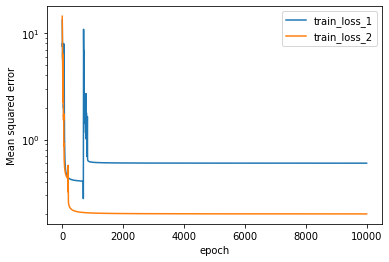

In [474]:
# 結果の出力と描画
plt.figure()
plt.plot(range(1, n_epoch+1), history_1['train_loss_1'], label='train_loss_1')
plt.plot(range(1, n_epoch+1), history_2['train_loss_2'], label='train_loss_2')
plt.plot(range(1, n_epoch+1), history_3['train_loss_3'], label='train_loss_3')
plt.xlabel('epoch')
plt.ylabel('Mean squared error')
plt.legend()
plt.yscale("log")
plt.savefig('loss.png')



In [475]:
print(output_2[6].weight_g)

Parameter containing:
tensor([[0.5898],
        [0.7944],
        [0.7555],
        [0.5669],
        [0.6610],
        [0.5457],
        [0.6833],
        [0.4476],
        [0.5096],
        [0.5466]], requires_grad=True)


In [476]:
print(spin_overlap(output_1[5], SL))
print(spin_overlap(output_2[5], SL))

tensor(0.9700, grad_fn=<AbsBackward>)
tensor(0.9900, grad_fn=<AbsBackward>)


In [477]:
#print(output_1[7].weight)
J1_1 = N**(1/2) * output_1[6].weight/output_1[11]
J2_1 = N**(1/2) * output_1[7].weight/output_1[12]
J3_1 = N**(1/2) * output_1[8].weight/output_1[13]
J4_1 = N**(1/2) * output_1[9].weight/output_1[14]
J5_1 = N**(1/2) * output_1[10].weight/output_1[15]

print(bond_overlap(J2_1,J2_1))

tensor(1.0000, grad_fn=<AbsBackward>)


In [478]:
S1_1 = output_1[1]
S2_1 = output_1[2]
S3_1 = output_1[3]
S4_1 = output_1[4]
S5_1 = output_1[5]

print(spin_overlap(S2_1,S2_1))

tensor(1., grad_fn=<AbsBackward>)


In [479]:
J1_2 = N**(1/2) * output_2[6].weight/output_2[11]
J2_2 = N**(1/2) * output_2[7].weight/output_2[12]
J3_2 = N**(1/2) * output_2[8].weight/output_2[13]
J4_2 = N**(1/2) * output_2[9].weight/output_2[14]
J5_2 = N**(1/2) * output_2[10].weight/output_2[15]

print(bond_overlap(J2_2,J2_2))

tensor(1.0000, grad_fn=<AbsBackward>)


In [480]:
S1_2 = output_2[1]
S2_2 = output_2[2]
S3_2 = output_2[3]
S4_2 = output_2[4]
S5_2 = output_2[5]

print(spin_overlap(S2_2,S2_2))

tensor(1., grad_fn=<AbsBackward>)
